**Galactic Variability Timescales Figures of Merit**

In [178]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import healpy as hp
import astropy.units as u
from astropy.coordinates import SkyCoord
from matplotlib.patches import Rectangle

This notebook is designed to present Figures of Merit (FoM) that *very approximately* explore how different categories of galactic variability will benefit or suffer depending on the survey footprint used and total number of visits dedicated to this survey region.  

**Assumptions:**
* The distribution of the visits are uniform in time, i.e. intervals between visits are constant
* Equal numbers of visits are obtained in all 6 filters, repeating sequentially, so that color information is obtained

**MAJOR CAVEAT:** this dramatically simplifies the requirements of the science involved, particularly in the distribution of the visits throughout the survey and the relative time allocated to obtaining data in different filters.  This is an unsafe and potentially misleading assumption and caution is strongly advised in interpreting the results on this basis alone. 

**Categorizing variability according to timescale**

We group all types of galactic stellar variabililty into either transient and periodic phenomena, and consider four very broad categories based on the characteristic *timescale of variability* $\tau_{var}$, since this is the key characteristic affected by changes in lightcurve time sampling when more or fewer visits to a given pointing are made in the course of the survey.  
For transient phenomena, the timescale of variability refers to typical duration of the transient signal, such as the duration of an outburst or explosion, or the Einstein crossing timescale in microlensing.  
For periodic phenomena, the timescale of variability is considered to be the primary periodicity of the object, typically the rotation or orbital period.  

Galactic variability can then be grouped into the following categories according to $\tau_{var}$:
* $<$10 days: including exoplanet & White Dwarf transits, stellar flares, short period stellar binaries, pulsating stars (inc. RR Lyrae, Cepheids), some point-source microlensing (e.g., by free-floating planets, bound planet anomalies, brown dwarfs), most binary microlensing, variability in young stars, short-term accretion variability
* 10-100 days: includes point-source microlensing by galactic stellar-mass lenses (but not binary-lens anomalies), intermediate stellar pulsation periods, disk instability in Cataclysmic Variables, novae
* 100-365 days: includes microlensing by black holes, long-timescale pulsations, 
* $>$365 days: includes long-period variables, e.g. Miras

Although LSST will generate an alert whenever an object varies by more than 5$\sigma$ from the reference flux, for most of Galactic science this is insufficient to reliably detect variability and certainly inadequate to meaningfully classify it.  

Based on previous follow-up experience we require a minimum of 5 observations taken within $\tau_{var}$ to consider a variable target "detectable" in the sense of being able to accurately extract targets of interest from the LSST datastream (for comparison we understand the ZTF estimate that 10 observations are required).  

Applying this requirement to transient phenomena, we derive a maximum-useful observation interval, $\tau_{obs} = \tau_{var} / 5$ for the four categories above:
* $\tau_{var} < $10 days, $\tau_{obs}$ = 2days
* 10 $<$ $\tau_{var} < $100 days, $\tau_{obs}$ = 2 - 20 days
* 100 $<$ $\tau_{var} < $365 days, $\tau_{obs}$ = 20 - 73 days
* $\tau_{var} > $365 days, $\tau_{obs}$ = 73days

It is often assumed that periodic variables will automatically be detected over the lifetime of LSST.   More precisely, an accurate period, $P$, should be recovered if at least ~5 observations are obtained spanning a range of different phases of the variability period, and this is indeed likely to be true for all $\tau_{var}$ categories after the 10yr survey.  However, *the early identification of periodic variables is critical to the accurate classification of transients*, so waiting until year 10 to identify all periodic variables would severely limit the transient science that can be done, as well as delaying variable star science.  

On the assumption that Galactic Plane visits are uniformly distributed throughout the survey, we therefore consider the detection of periodic variables based on observations taken *only within the first year*.  The maximum-useful observation interval is then set by requiring $\tau_{obs} = P / 5$, leading to the same $\tau_{obs}$ categories as above.

**Galactic Plane Survey Footprint**

To first order, the spatial distribution of all of these classes of variable follows the distribution of stars in the Milky Way, which we represent using the TVS/SMWLV Galactic Plane priority map.  This map assigns a numerical priority to each HEALpix in the sky according to that pixels importance in Galactic Plane science (as described in Street et al. 2021 https://docushare.lsst.org/docushare/dsweb/Get/Document-37639/Galactic_Plane_Footprint.pdf).

Note that the SDSS-i band map is used here as the most generally-applicable and inclusive reference.  

In [60]:
footprint_maps_dir = os.getenv('FOOTPRINT_MAPS_DIR')
GP_footprint = hp.read_map(os.path.join(footprint_maps_dir,'GalPlane_priority_map_i.fits'), dtype=np.float64)

In [75]:
def galPlane_survey_footprint(healpix_priority_minimum_threshold = 0.25):
    galwfd = np.where(GP_footprint >= healpix_priority_minimum_threshold,1,0)
    return galwfd

To give illustrative examples, the following plots show how the survey footprint changes when we include only the higher-priority areas.

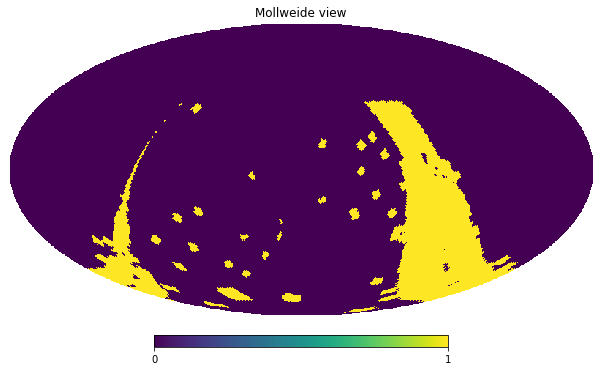

In [76]:
galwfd = galPlane_survey_footprint(healpix_priority_minimum_threshold = 0.25)
hp.mollview(galwfd, max=1)

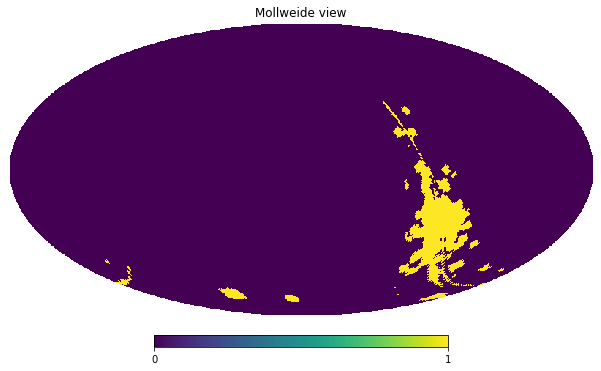

In [77]:
galwfd = galPlane_survey_footprint(healpix_priority_minimum_threshold = 0.5)
hp.mollview(galwfd, max=1)

One dimension of survey strategy optimization is to consider larger vs smaller footprints in the Galactic Plane, which can be done by lowering or increasing (respectively) the healpix_priority_minimum_threshold.  We estimate the total survey area included in the Galactic Plane as a function of healpix_priority_minimum_threshold as follows.

In [81]:
def estimate_GP_survey_area(galwfd, nside=64):
    gp_area = galwfd.sum() * hp.nside2pixarea(nside, degrees=True)
    return gp_area

In [82]:
priority_range = np.arange(0.1,1.0,0.1)
survey_area = np.zeros(len(priority_range))
for i in range(0,len(priority_range),1):
    galwfd = galPlane_survey_footprint(healpix_priority_minimum_threshold=priority_range[i])
    survey_area[i] = estimate_GP_survey_area(galwfd)
data = np.column_stack((priority_range,survey_area))

Text(0, 0.5, 'Survey area (sq deg)')

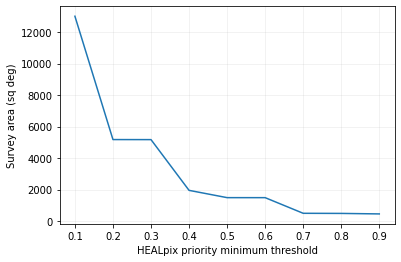

In [83]:
plt.plot(data[:,0], data[:,1])
plt.grid(alpha=0.2)
plt.xlabel('HEALpix priority minimum threshold')
plt.ylabel('Survey area (sq deg)')

**Survey Time Requirements**

To estimate the time required to survey a given region, we calculate the observing time required for a single visit, based on 2x15s exposures, with a mean visit time of 42.2s (from https://www.lsst.org/scientists/keynumbers).  

In [88]:
def calc_survey_time(nvisits_per_pointing,survey_area):
    """Estimates the total on-sky observing time used to survey a footprint of a given area, 
    for the number of visits indicated.  Estimate is returned in units of hours."""
    mean_visit_time = 42.2/3600.0  # secs -> hours
    npointings = survey_area / 9.6 # Estimated from the Rubin FOV=9.6 sq deg
    survey_time = mean_visit_time * nvisits_per_pointing * npointings
    return survey_time

To build intuition, let's calculate the amount of time required to survey the Galactic Plane to different HEALpix priority levels, assuming the default 825 visits per field, and compare this with a rough estimate of the total observing time for the LSST survey:

In [89]:
survey_time = np.zeros(len(priority_range))
for i in range(0,len(priority_range),1):
    survey_time[i] = calc_survey_time(825, survey_area[i])
data = np.column_stack((priority_range,survey_area,survey_time))
print(data)

[[1.00000000e-01 1.30048550e+04 1.31008110e+04]
 [2.00000000e-01 5.17508462e+03 5.21326883e+03]
 [3.00000000e-01 5.17172744e+03 5.20988689e+03]
 [4.00000000e-01 1.95051843e+03 1.96491028e+03]
 [5.00000000e-01 1.48806763e+03 1.49904730e+03]
 [6.00000000e-01 1.48722834e+03 1.49820181e+03]
 [7.00000000e-01 4.94343957e+02 4.97991460e+02]
 [8.00000000e-01 4.86790314e+02 4.90382083e+02]
 [9.00000000e-01 4.54897156e+02 4.58253602e+02]]


In [92]:
nyears = 10.0
ndays_per_year = 365.0
nhours_per_night = 9.0
clear_fraction = 0.8
total_lsst_survey_time = nyears * ndays_per_year * nhours_per_night * clear_fraction
print('Total number of hours of observations in LSST = '+str(total_lsst_survey_time)+'hrs')
available_lsst_fraction = 0.1
available_survey_time = total_lsst_survey_time * available_lsst_fraction
print('Estimate number of hours available for non-WFD observations = '+str(available_survey_time)+'hrs')

Total number of hours of observations in LSST = 26280.0hrs
Estimate number of hours available for non-WFD observations = 2628.0hrs


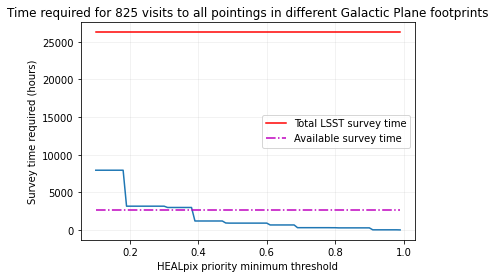

In [134]:
plt.plot(data[:,0], data[:,2])
plt.grid(alpha=0.2)
plt.plot([data[:,0].min(),data[:,0].max()],[total_lsst_survey_time]*2,'r-',label='Total LSST survey time')
plt.plot([data[:,0].min(),data[:,0].max()],[available_survey_time]*2,'m-.',label='Available survey time')
plt.xlabel('HEALpix priority minimum threshold')
plt.ylabel('Survey time required (hours)')
plt.title('Time required for 825 visits to all pointings in different Galactic Plane footprints')
plt.legend()

**Impact of Number of Observations on Scientific Yield**

If the total amount of Rubin observing time dedicated to surveying the Galactic Plane has to be reduced due to other scheduling pressures, what impact will this have on galactic variability science?

For simplicity, we assume that if the total number of visits to a field is reduced, the remaining visits are distributed uniformly (in time and in filter selection) and so the interval between visits increases.  We can therefore *roughly* gauge the scientific impact of this change by comparing the inter-visit interval with $\tau_{var}$ and $\tau_{obs}$.  


In [266]:
def estimate_visit_interval(nvisits):
    """Function to estimate the interval between visits to a given pointing 
    based on the total number of visits over the lifetime of the survey.  
    This assumes that:
    - Any given field is observable from site for an average of 8 months per year
    - The survey lifetime is 10 years
    - Visits to the field are uniformly distributed
    - The average observing night is 9hrs long
    """
    
    # Estimate the total period of time for which a field can be observed by Rubin
    # over the lifetime of LSST.  Units of hours
    total_time_field_observable = 10.0 * 8.0 * 30.0 * 9.0
    
    # Average interval between visits in hours
    visit_interval = total_time_field_observable / nvisits
    
    return visit_interval

Text(0.5, 1.0, 'Zoom into short observation intervals')

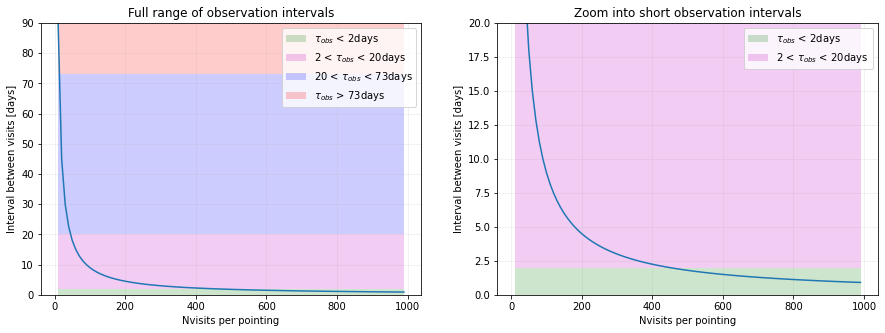

In [267]:
fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(15,5))
ax1.plot(nvisits_range, visit_intervals)
ax1.grid(alpha=0.2)
ax1.set_xlabel('Nvisits per pointing')
ax1.set_ylabel('Interval between visits [days]')
ax1.fill_between(nvisits_range, 0.0, 2.0, facecolor='green', alpha=0.2, label='$\\tau_{obs}$ < 2days')
ax1.fill_between(nvisits_range, 2.0, 20.0, facecolor='m', alpha=0.2, label='2 < $\\tau_{obs}$ < 20days')
ax1.fill_between(nvisits_range, 20.0, 73.0, facecolor='b', alpha=0.2, label='20 < $\\tau_{obs}$ < 73days')
ax1.fill_between(nvisits_range, 73.0, 100.0, facecolor='r', alpha=0.2, label='$\\tau_{obs}$ > 73days')
(xmin,xmax,ymin,ymax) = ax1.axis()
ax1.axis([xmin,xmax,0.0,visit_intervals.max()])
ax1.legend()
ax1.set_title('Full range of observation intervals')


ax2.plot(nvisits_range, visit_intervals)
ax2.grid(alpha=0.2)
ax2.set_xlabel('Nvisits per pointing')
ax2.set_ylabel('Interval between visits [days]')
ax2.fill_between(nvisits_range, 0.0, 2.0, facecolor='green', alpha=0.2, label='$\\tau_{obs}$ < 2days')
ax2.fill_between(nvisits_range, 2.0, 20.0, facecolor='m', alpha=0.2, label='2 < $\\tau_{obs}$ < 20days')
(xmin,xmax,ymin,ymax) = ax2.axis()
ax2.axis([xmin,xmax,0.0,20.0])
ax2.legend()
ax2.set_title('Zoom into short observation intervals')

The plot above illustrates which categories of galactic plane science will be served, given different numbers of total visits, assuming they are distributed uniformly in time and filter selection. **However caution is urged in interpreting these plots** The four $\tau_{obs}$ categories are not considered scientifically equal in the sense that the **majority of high-impact science is contained within the category $\tau_{obs} < 2$ days.**  

If LSST does not provide sufficient numbers of visits to achieve this science, it is possible that some of it may still be achieved through real-time follow-up observations at higher cadence.  This has been demonstrated with microlensing for example, if the survey provides sufficient observations to alert new discoveries at an early stage of the event.  **But we stress that follow-up observations cannot fully compensate for the loss of Rubin observations** particularly at fainter magnitudes, as inadequate time is available at follow-up facilities of sufficient aperture and instrumentation, and the scientific yield of the survey would be substantially diminished.

**Impact of Survey Footprint Area**

From the plots above, we note that nvisits~500/pointing provides a rough rule-of-thumb as the minimum viable number of visits that would enable science in all four $\tau_{var}$ categories.  We combine this with the Galactic Plane priority map to estimate the total survey time required for different footprints. 

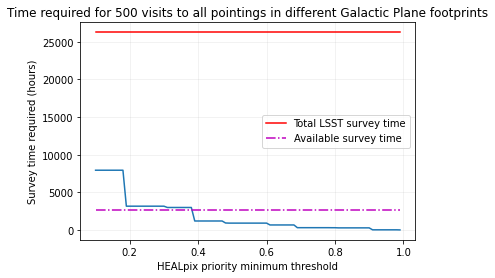

In [133]:
priority_range = np.arange(0.1,1.0,0.01)
survey_area = np.zeros(len(priority_range))
survey_time = np.zeros(len(priority_range))
for i in range(0,len(priority_range),1):
    galwfd = galPlane_survey_footprint(healpix_priority_minimum_threshold=priority_range[i])
    survey_area[i] = estimate_GP_survey_area(galwfd)
    survey_time[i] = calc_survey_time(500, survey_area[i])
data = np.column_stack((priority_range,survey_area,survey_time))
plt.plot(data[:,0], data[:,2])
plt.grid(alpha=0.2)
plt.plot([data[:,0].min(),data[:,0].max()],[total_lsst_survey_time]*2,'r-',label='Total LSST survey time')
plt.plot([data[:,0].min(),data[:,0].max()],[available_survey_time]*2,'m-.',label='Available survey time')
plt.xlabel('HEALpix priority minimum threshold')
plt.ylabel('Survey time required (hours)')
plt.title('Time required for 500 visits to all pointings in different Galactic Plane footprints')
plt.legend()

This plot implies that using a HEALpix-priority threshold of 0.4 to select fields in the Galactic Plane might be surveyed to an adequate cadence by LSST to enable all of the science considered here.  To illustrate that footprint graphically:

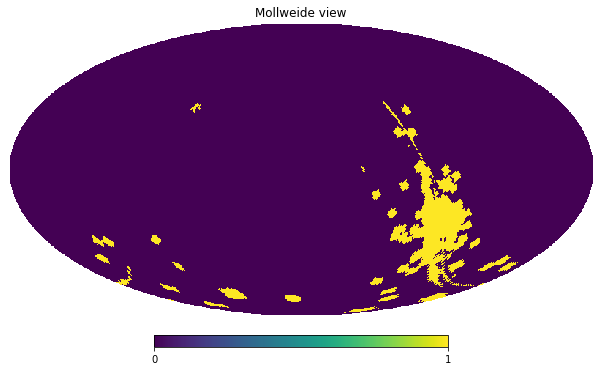

In [136]:
galwfd = galPlane_survey_footprint(healpix_priority_minimum_threshold = 0.4)
hp.mollview(galwfd, max=1)

**Galactic Science Figure of Merit**

A very approximate rule of thumb for galactic science may be derived by combining the above metrics for survey footprint and number of visits per pointing.  To give a sense of scale, we normalize this FoM using intermediate values for survey footprint area of 2000 sq deg. and nvisits_per_pointing of 500, based on the analysis above.  

In [177]:
def GP_FoM_tau_footprint(nvisits_per_pointing,survey_area):
    
    visit_intervals = estimate_visit_interval(nvisits_per_pointing) / 24.0
    FoM = survey_area / visit_intervals
    
    minimum_visit_interval = estimate_visit_interval(500) / 24.0
    fiducial_FoM = 2000.0 / minimum_visit_interval
    
    norm_FoM = FoM/fiducial_FoM
    
    return norm_FoM

89.5 -0.5


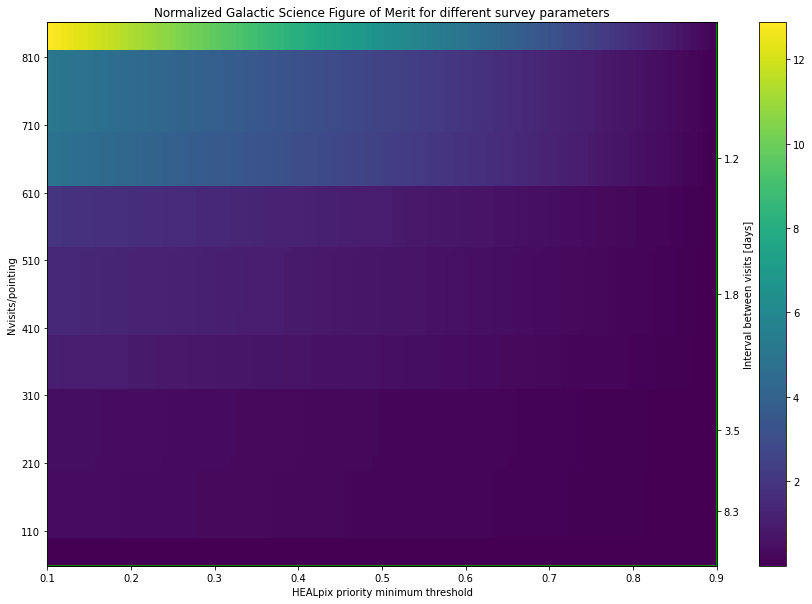

In [273]:
min_nvisits = 10
max_nvisits = 1000
nvisits_range = np.arange(min_nvisits,max_nvisits,10)
visit_intervals = estimate_visit_interval(nvisits_range) / 24.0
min_priority = 0.1
max_priority = 1.0
priority_range = np.arange(min_priority, max_priority,0.01)
FoM = np.zeros((len(priority_range),len(nvisits_range)))
survey_time = np.zeros((len(priority_range),len(nvisits_range)))
for i in range(0,len(priority_range),1):
    galwfd = galPlane_survey_footprint(healpix_priority_minimum_threshold=priority_range[i])
    survey_area = estimate_GP_survey_area(galwfd)
    survey_time[i,:] = calc_survey_time(500, survey_area)
    FoM[i,:] = GP_FoM_tau_footprint(nvisits_range,survey_area)
FoM = np.flip(FoM,1)
fig, ax = plt.subplots(1, 1,figsize=(15,10))
ax.imshow(FoM, interpolation='none')
ax.set_xlabel('HEALpix priority minimum threshold')
ax.set_ylabel('Nvisits/pointing')
(xmin,xmax,ymin,ymax) = plt.axis()
print(ymin,ymax)
priority_intervals = np.arange(min_priority, max_priority, 0.1)
nvisits_intervals = np.arange(min_nvisits,max_nvisits,100)
plt.xticks(np.linspace(xmin,xmax,len(priority_intervals)), [str(round(p,1)) for p in priority_intervals])
plt.yticks(np.linspace(ymin,ymax,len(nvisits_intervals)), [str(round(n)) for n in nvisits_intervals])
plt.colorbar(im)
plt.title('Normalized Galactic Science Figure of Merit for different survey parameters')

ax2 = ax.twinx()
yincr = max_nvisits - min_nvisits
y2entries = np.array([0.1,0.25, 0.5, 0.75])
y2values = min_nvisits + y2entries*yincr
y2range = estimate_visit_interval(y2values) / 24.0

ax2.set_ylabel('Interval between visits [days]')
ax2.set_yticks(y2entries)
ax2.set_yticklabels([str(round(n,1)) for n in y2range])
#ax2.invert_yaxis()


rect = Rectangle((xmin, 0.0), (xmax-xmin), 2.0, linewidth=2, edgecolor='g', facecolor='none')
ax2.add_patch(rect)
rect = Rectangle((xmin, 2.0), (xmax-xmin), 18.0, linewidth=2, edgecolor='m', facecolor='none')
ax2.add_patch(rect)
rect = Rectangle((xmin, 20.0), (xmax-xmin), 53.0, linewidth=2, edgecolor='b', facecolor='none')
ax2.add_patch(rect)
rect = Rectangle((xmin, 73.0), (xmax-xmin), 27.0, linewidth=2, edgecolor='r', facecolor='none')
ax2.add_patch(rect)

The figure above shows the normalized FoM calculated for a range of survey designs, where the colorbar indicates values of the FoM.  The y-axis represents the number of pointings per field and the second y-axis displays the corresponding interval between sequential observation.  The superimposed boxes indicate the approximate regions where the interval between visits exceeds $\tau_{var}$ for the four categories of variability timescale; the color of the box outline corresponds to the plot colors used in the plots of interval between obs vs. Nvisits.  This gives an intuitive sense of the survey parameters that will service different science cases, though the caveats above are again strongly emphasized.  

In [241]:
for i, nv in enumerate(nvisits_range):
    print(nv, visit_intervals[i])

10 90.0
20 45.0
30 30.0
40 22.5
50 18.0
60 15.0
70 12.857142857142856
80 11.25
90 10.0
100 9.0
110 8.181818181818182
120 7.5
130 6.923076923076923
140 6.428571428571428
150 6.0
160 5.625
170 5.294117647058823
180 5.0
190 4.736842105263158
200 4.5
210 4.285714285714286
220 4.090909090909091
230 3.9130434782608696
240 3.75
250 3.6
260 3.4615384615384617
270 3.3333333333333335
280 3.214285714285714
290 3.103448275862069
300 3.0
310 2.9032258064516125
320 2.8125
330 2.727272727272727
340 2.6470588235294117
350 2.5714285714285716
360 2.5
370 2.4324324324324325
380 2.368421052631579
390 2.307692307692308
400 2.25
410 2.195121951219512
420 2.142857142857143
430 2.093023255813953
440 2.0454545454545454
450 2.0
460 1.9565217391304348
470 1.9148936170212767
480 1.875
490 1.836734693877551
500 1.8
510 1.7647058823529411
520 1.7307692307692308
530 1.6981132075471699
540 1.6666666666666667
550 1.6363636363636365
560 1.607142857142857
570 1.5789473684210524
580 1.5517241379310345
590 1.5254237288135